In [1]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from matplotlib import rcParams
from pandas.io.json import json_normalize
from collections import ChainMap
import ast
from sklearn.feature_selection import mutual_info_regression
#import fuzzywuzzy
#from fuzzywuzzy import process

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# sns.set(rc={'figure.figsize':(20,10)})
# plt.style.use(
#     "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
# )
# rcParams['figure.figsize'] = 20,10
sns.set_theme()

# Relevant functions

In [3]:
def descriptive_table(data):
  " Function that outputs descriptive data"

  sum_table = data.describe().round(1)
  sum_table = sum_table.T
  return sum_table

def flattened_cols(col_name):
  """
  extracts nested dict, returns df of them
  """
  dictionary_data = asset_df[col_name].to_dict()
  dist_flat = []

  for key, value in dictionary_data.items():
    dist_flat.append(value)

  dictionary_clean = []  #string dict to dict 
  for i in dist_flat:
    dictionary_clean.append(ast.literal_eval((i)))

  flattend_df = pd.DataFrame(dictionary_clean)
  return flattend_df

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

# data cleaning

In [4]:
# flaggin consensus
# asset_df["consensus__general_consensus_mechanism"].fillna(" ", inplace=True)
# asset_df["PROOF-OF-WORK"] = [1 if "PROOF-OF-WORK" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DELEGATED PROOF-OF-STAKE"] = [1 if "DELEGATED PROOF-OF-STAKE" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & POS"] = [1 if "HYBRID POW & POS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, DAG"] = [1 if "PROOF-OF-STAKE, DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DAG"] = [1 if "DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-WORK, OTHER"] = [1 if "PROOF-OF-WORK, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, OTHER"] = [1 if "PROOF-OF-STAKE, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & DPOS"] = [1 if "HYBRID POW & DPOS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]

# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.upper()
# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.strip()
# asset_df['consensus__general_consensus_mechanism'].replace( { r"OTHER, PROOF-OF-WORK" : 'PROOF-OF-WORK, OTHER' }, inplace= True, regex = True)

#flattened_assets = flattened_assets.join(fund_df)

# Initial Data EDA

In [5]:
asset_df = pd.read_csv('/content/super_super_final_crypto.csv')
assets_fundraise = pd.read_csv('/content/assets_fundraise.csv')

In [6]:
descstats_assetfund = descriptive_table(assets_fundraise)
descstats_assetfund 

,count,mean,std,min,25%,50%,75%,max
Total Raised,180.0,5.807500e+07,3.239694e+08,72355.0,4812500.0,14925000.0,32211953.5,4.196874e+09
Total supply,203.0,9.919612e+11,9.851137e+12,212503.0,38887609.5,100000000.0,640243508.5,9.999900e+13
Private/Pre-sale,67.0,3.662030e+09,1.871633e+10,1450000.0,37850000.0,133333334.0,725700000.0,1.498500e+11
Public sale,103.0,1.950093e+11,1.970562e+12,30000.0,10000000.0,47000000.0,193863734.5,1.999980e+13


Text(0.5, 1.0, 'Total raised per token (All_time)')

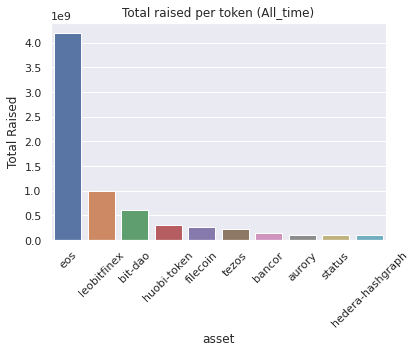

In [7]:
# ico barplot
highest_raised = assets_fundraise.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised.head(10))
ax.set_xticklabels(labels = highest_raised.asset,rotation=45)
ax.set_title("Total raised per token (All_time)", loc="center")

In [8]:
#types of funding
assets_fundraise['R1 type'].unique()

array(['Private ', 'ICO ', 'Private/Pre-sale ', 'IEO ', 'IDO ', nan,
       'Seed ', 'Private 2 '], dtype=object)

Text(0.5, 1.0, 'Total raised from ICO per token (r1)')

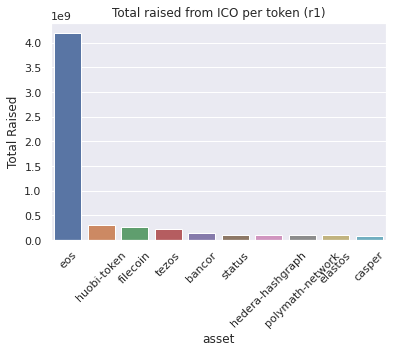

In [9]:
#test_assets_fundraise = assets_fundraise.str.strip()
assets_fundraise['R1 type'] = assets_fundraise['R1 type'].str.strip()
highest_raised_ico_r1 = assets_fundraise[assets_fundraise['R1 type'] == "ICO"]
highest_raised_ico_r1 = highest_raised_ico_r1.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised_ico_r1.head(10))
ax.set_xticklabels(labels = highest_raised_ico_r1.asset,rotation=45)
ax.set_title("Total raised from ICO per token (r1)", loc="center")


# Mutual information score

In [10]:
# rename col name for consistency
#df.rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}, inplace = True)

asset_df.rename(columns = {'name':'asset',}, inplace = True)
asset_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [11]:
# check missing values as there are alot before we run mi score
missing_values_count = asset_df.isnull().sum().sort_values(ascending=False)
missing_values_count.head(10)

lines_added_last_3_months                  500
lines_deleted_last_1_year                  500
roi_since_sale_btc_percent                 500
commits_last_1_year                        500
lines_added_last_1_year                    500
roi_since_sale_usd_percent                 500
sale_end_date                              500
sale_start_date                            500
native_treasury__treasury_usage_details    500
ohlcv_last_1_hour                          500
dtype: int64

In [12]:
assets_fundraise.isnull().sum().sort_values(ascending=False).tail(10)

Public sale     100
R1 Raise         48
Total Raised     23
R1 Price         19
R1 ROI           19
R1 ATH ROI       19
R1 date          14
R1 type          13
Total supply      0
asset             0
dtype: int64

In [13]:
total_cells = np.product(asset_df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

52.00733944954128


## combine dataset asset fundraise with asset as there are too many missing values

In [14]:
# ensuring they all have same name
assets_fundraise['asset'] = assets_fundraise['asset'].str.lower()
asset_df['asset'] = asset_df['asset'].str.lower()

assets_fundraise['asset'] = assets_fundraise['asset'].str.strip()
asset_df['asset'] = asset_df['asset'].str.strip()

In [15]:
asset_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [16]:
combined_df = pd.merge(asset_df,assets_fundraise,on='asset',how='outer')
combined_df.head(3)

,Unnamed: 0,Unnamed: 0.1,asset,symbol,price_usd,price_btc,price_eth,volume_last_24_hours,real_volume_last_24_hours,volume_last_24_hours_overstatement_multiple,percent_change_usd_last_1_hour,percent_change_btc_last_1_hour,percent_change_eth_last_1_hour,percent_change_usd_last_24_hours,percent_change_btc_last_24_hours,percent_change_eth_last_24_hours,ohlcv_last_1_hour__open,ohlcv_last_1_hour__high,ohlcv_last_1_hour__low,ohlcv_last_1_hour__close,ohlcv_last_1_hour__volume,ohlcv_last_24_hour__open,ohlcv_last_24_hour__high,ohlcv_last_24_hour__low,ohlcv_last_24_hour__close,ohlcv_last_24_hour__volume,last_trade_at,rank,marketcap_dominance_percent,current_marketcap_usd,y_2050_marketcap_usd,y_plus10_marketcap_usd,liquid_marketcap_usd,volume_turnover_last_24_hours_percent,realized_marketcap_usd,outstanding_marketcap_usd,y_2050,y_plus10,liquid,circulating,y_2050_issued_percent,annual_inflation_percent,stock_to_flow,y_plus10_issued_percent,supply_revived_90d,sale_proceeds_usd,sale_start_date,sale_end_date,roi_since_sale_usd_percent,roi_since_sale_btc_percent,roi_since_sale_eth_percent,stars,watchers,commits_last_3_months,commits_last_1_year,lines_added_last_3_months,lines_added_last_1_year,lines_deleted_last_3_months,lines_deleted_last_1_year,percent_change_last_1_week,percent_change_last_1_month,percent_change_last_3_months,percent_change_last_1_year,percent_change_btc_last_1_week,percent_change_btc_last_1_month,percent_change_btc_last_3_months,percent_change_btc_last_1_year,percent_change_eth_last_1_week,percent_change_eth_last_1_month,percent_change_eth_last_3_months,percent_change_eth_last_1_year,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,2021_usd_percent,2020_usd_percent,2019_usd_percent,2018_usd_percent,2017_usd_percent,2016_usd_percent,2015_usd_percent,2014_usd_percent,2013_usd_percent,2012_usd_percent,2011_usd_percent,sharpe_ratios__last_30_days,sharpe_ratios__last_90_days,sharpe_ratios__last_1_year,sharpe_ratios__last_3_years,volatility_stats__volatility_last_30_days,volatility_stats__volatility_last_90_days,volatility_stats__volatility_last_1_year,volatility_stats__volatility_last_3_years,supply_active_10y,supply_active_180d,supply_active_1d,supply_active_1y,supply_active_1y_percent,supply_active_2y,supply_active_30d,supply_active_3y,supply_active_4y,supply_active_5y,supply_active_7d,supply_active_90d,supply_active_ever,outstanding,supply_revived_1y,supply_revived_2y,supply_revived_30d,supply_revived_3y,supply_revived_4y,supply_revived_5y,supply_revived_7d,supply_in_addresses_balance_greater_0_001_native_units,supply_in_addresses_balance_greater_0_01_native_units,supply_in_addresses_balance_greater_0_1_native_units,supply_in_addresses_balance_greater_1_usd,supply_in_addresses_balance_greater_10_usd,supply_in_addresses_balance_greater_100_usd,supply_in_addresses_balance_greater_100k_usd,supply_in_addresses_balance_greater_100k_native_units,supply_in_addresses_balance_greater_100_native_units,supply_in_addresses_balance_greater_10k_usd,supply_in_addresses_balance_greater_10k_native_units,supply_in_addresses_balance_greater_10m_usd,supply_in_addresses_balance_greater_10_native_units,supply_in_addresses_balance_greater_1k_usd,supply_in_addresses_balance_greater_1k_native_units,supply_in_addresses_balance_greater_1m_usd,supply_in_addresses_balance_greater_1m_native_units,supply_in_addresses_balance_greater_1_native_units,supply_in_contracts_usd,supply_in_contracts_native_units,supply_shielded,supply_in_top_100_addresses,supply_in_top_10_percent_addresses,supply_in_top_1_percent_addresses,supply_in_utxo_in_loss,supply_in_utxo_in_profit,token__token_name,token__token_type,token__token_address,token__token_usage,token__token_usage_details,general__launch_style,general__launch_details,fundraising__sales_rounds,fundraising__sales_documents,fundraising__sales_treasury_accounts,fundraising__treasury_policies,fundraising__projected_use_of_sales_proceeds,initial_distribution__initial_supply,initial_

In [17]:
combined_df['start_year'] = np.where(combined_df['start_year'].isnull() == True, combined_df['initial_distribution__genesis_block_year'], combined_df['start_year'])

In [18]:
combined_df = combined_df[combined_df['start_year'].notna()]

In [19]:
#combined_df.to_csv('super_super_super_final.csv')

In [20]:
#combined_df.isnull().sum().sort_values(ascending=False).head(1000)

In [54]:
combined_df.isnull().sum().sort_values(ascending=False)

supply_in_utxo_in_profit                                  208
supply_shielded                                           208
R5 Lock-up                                                208
R5 Raise                                                  208
R4 Min/Max personal Cap                                   208
R4 Lock-up                                                208
R4 Raise                                                  208
R3 Lock-up                                                208
supply_in_utxo_in_loss                                    208
R5 Min/Max personal Cap                                   208
R3 Raise                                                  207
R4 Tokens For Sale                                        207
R3 Min/Max personal Cap                                   207
R4 type                                                   207
R4 date                                                   207
R4 Price                                                  207
R4 ROI  

In [22]:
combined_df = combined_df.loc[:, combined_df.isin([' ','NULL',np.nan]).mean() < 1]

In [23]:
combined_df = combined_df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

In [24]:
combined_df.shape

(209, 249)

In [25]:
#fill 0 for certain cols
combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage','R1 type']] = combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage','R1 type']].fillna(0)

In [56]:
dropped_cols = ['outstanding_marketcap_usd','ohlcv_last_24_hour__volume','y_plus10_marketcap_usd','liquid_marketcap_usd','token__token_address','last_trade_at','volume_last_24_hours_overstatement_multiple','price_eth','price_btc','price_usd','real_volume_last_24_hours','volume_last_24_hours','symbol','consensus__general_consensus_mechanism','token__token_usage','token__token_usage_details','general__launch_details','fundraising__sales_rounds','fundraising__sales_documents','fundraising__sales_treasury_accounts','fundraising__treasury_policies','fundraising__projected_use_of_sales_proceeds','initial_distribution__token_distribution_date','initial_distribution__genesis_block_date','supply__supply_curve_details','consensus__consensus_details','consensus__precise_consensus_mechanism','consensus__mining_algorithm','consensus__next_halving_date','governance_details','onchain_governance__onchain_governance_type','onchain_governance__onchain_governance_details','title','start_date','type','details','end_date','restricted_jurisdictions','R1 ROI','R2 ROI','R3 ROI','R4 ROI','R5 ROI','R1 ATH ROI','R2 ATH ROI','R3 ATH ROI','R4 ATH ROI','R5 ATH ROI','rank','marketcap_dominance_percent']

# Check missing values in combined_df

potentially useful columns

* general__launch_style
* initial_distribution__initial_supply
* supply__general_emission_type
* supply__precise_emission_type
* supply__is_capped_supply

In [29]:
# combined_df.isnull().sum().sort_values(ascending=False)

# Impute missing data 

In [57]:
combined_df['general__launch_style'] = combined_df['general__launch_style'].fillna('not specified') # only 52 is missing so we can impute null value 'not specified'
combined_df['supply__general_emission_type'] = combined_df['supply__general_emission_type'].fillna('not specified') # 52 missing again, replace na with not specified
combined_df['supply__precise_emission_type'] = combined_df['supply__precise_emission_type'].fillna('not specified')
combined_df['supply__is_capped_supply'] = combined_df['supply__is_capped_supply'].fillna('not specified')


In [58]:
combined_df = combined_df.drop(dropped_cols,axis=1)

In [59]:
cleaned_assets = combined_df.dropna(axis=1) # drop all na

In [65]:
X = cleaned_assets.copy()
X = X.drop(columns=['asset'])
y = X.pop('current_marketcap_usd')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [66]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [69]:
mi_scores.head(10)

general__launch_style                               0.172466
supply__general_emission_type                       0.165179
supply__precise_emission_type                       0.138198
token__token_type                                   0.132227
native                                              0.079774
erc20                                               0.076185
allocated_to_organization_or_founders_percentage    0.068808
R1 type                                             0.067161
allocated_to_investors_percentage                   0.044214
usage__payments                                     0.038454
Name: MI Scores, dtype: float64

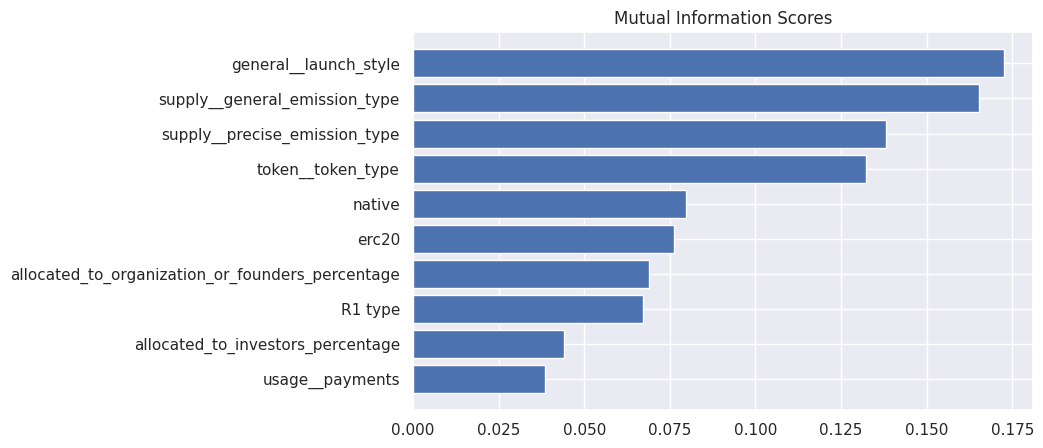

In [68]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

## Diff cleaning method

In [70]:
autofill_df = combined_df.fillna(0)

In [71]:
X = autofill_df.copy()
y = X.pop('current_marketcap_usd')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int


In [72]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [77]:
mi_scores.head(10)

y_2050_marketcap_usd              0.804792
token__token_name                 0.532611
asset                             0.496670
realized_marketcap_usd            0.216561
ohlcv_last_1_hour__close          0.208224
ohlcv_last_1_hour__open           0.207273
ohlcv_last_1_hour__low            0.206203
ohlcv_last_1_hour__high           0.205870
ohlcv_last_1_hour__volume         0.197381
percent_change_eth_last_1_hour    0.181634
Name: MI Scores, dtype: float64

Recheck data

In [93]:
descriptive_table(cleaned_assets).head(5)

,count,mean,std,min,25%,50%,75%,max
current_marketcap_usd,209.0,6.101972e+09,5.044152e+10,3118475.5,27338239.1,120201552.5,5.507598e+08,6.596436e+11
circulating,209.0,5.546765e+09,2.005907e+10,91121.3,66588888.0,288094211.0,1.165282e+09,1.840668e+11
percent_change_last_1_week,209.0,-8.700000e+00,8.100000e+00,-32.2,-12.1,-9.4,-5.600000e+00,2.720000e+01
percent_change_btc_last_1_week,209.0,1.000000e+00,8.900000e+00,-25.0,-2.8,0.2,4.400000e+00,4.060000e+01
percent_change_eth_last_1_week,209.0,2.000000e-01,8.900000e+00,-25.5,-3.5,-0.5,3.700000e+00,3.960000e+01


#### categorizing performance

In [79]:
marketcap_conditions = [
    (cleaned_assets['current_marketcap_usd'] < 27338239.1),
    (cleaned_assets['current_marketcap_usd'] >= 27338239.1) & (cleaned_assets['current_marketcap_usd'] < 120201552.5),
    (cleaned_assets['current_marketcap_usd'] >= 120201552.5) & (cleaned_assets['current_marketcap_usd'] < 5.507598e+08),
    (cleaned_assets['current_marketcap_usd'] >= 5.507598e+08)
]
marketcap_categories = ['low', 'medium', 'high','very high']
cleaned_assets['marketcap_categories'] = np.select(marketcap_conditions, marketcap_categories)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Average marketcap per year

In [80]:
# get average marketcap per year
cleaned_assets["MedianMarketcap_yearly"] = (
    cleaned_assets.groupby("start_year")
    ["current_marketcap_usd"]
    .transform("median")
) 

cleaned_assets[["start_year", "current_marketcap_usd", "MedianMarketcap_yearly"]].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,start_year,current_marketcap_usd,MedianMarketcap_yearly
0,2009.0,6.596436e+11,1.342765e+09
1,2014.0,3.091416e+11,5.861808e+08
3,2017.0,5.818232e+10,1.124840e+08
6,2020.0,2.632893e+10,2.037711e+08
7,2017.0,2.513058e+10,1.124840e+08
8,2019.0,2.133582e+10,5.030024e+08
11,2013.0,1.666530e+10,5.090272e+07
12,2020.0,1.444531e+10,2.037711e+08
13,2020.0,1.334395e+10,2.037711e+08
16,2018.0,8.496035e+09,5.337451e+07


In [81]:
cleaned_assets.head()

,asset,current_marketcap_usd,circulating,percent_change_last_1_week,percent_change_btc_last_1_week,percent_change_eth_last_1_week,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,sharpe_ratios__last_30_days,volatility_stats__volatility_last_30_days,token__token_type,general__launch_style,supply__general_emission_type,supply__precise_emission_type,supply__is_capped_supply,PROOF-OF-WORK,DELEGATED PROOF-OF-STAKE,HYBRID POW & POS,"PROOF-OF-STAKE, DAG",DAG,"PROOF-OF-WORK, OTHER","PROOF-OF-STAKE, OTHER",HYBRID POW & DPOS,allocated_to_investors_percentage,allocated_to_organization_or_founders_percentage,erc20,native,omni,trc20,trc10,bep2,bep20,erc777,ardor,spl,eosio,usage__payments,usage__work,usage__access,usage__discount,usage__vote,usage__dividends,start_year,R1 type,marketcap_categories,MedianMarketcap_yearly
0,bitcoin,6.596436e+11,1.903264e+07,-9.569280,0.000000,-0.700324,-9.569280,-24.850741,-27.116804,-3.751188,0.543354,Native,Fair Launch,Inflationary,Decreasing Issuance,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,0,very high,1.342765e+09
1,ethereum,3.091416e+11,1.206741e+08,-8.935813,0.704918,0.000000,-8.935813,-25.565467,-31.695333,-3.073505,0.584664,Native,Crowdsale,Inflationary,Fixed Issuance,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.47,16.53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2014.0,0,very high,5.861808e+08
3,bnb,5.818232e+10,1.632770e+08,-8.226820,1.488970,0.773797,-8.226820,-20.096473,-32.159224,-2.236757,0.563889,"Native, ERC-20",Crowdsale,Deflationary,Non-programmatic burn,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,50.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2017.0,0,very high,1.124840e+08
6,solana,2.632893e+10,3.346929e+08,-11.688968,-2.339706,-3.027899,-11.688968,-41.131020,-55.785941,-4.076844,0.856930,Native,"Auctions, Private Sale",Inflationary,Decreasing Inflation rate,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.00,25.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.0,Private,very high,2.037711e+08
7,cardano,2.513058e+10,3.382026e+10,-5.503159,4.500979,3.764581,-5.503159,-35.993120,-45.931638,-3.228148,0.971809,Native,Crowdsale,Inflationary,Decreasing Issuance,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.33,16.67,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2017.0,ICO,very high,1.124840e+08


In [90]:
cleaned_assets.shape

(209, 47)

In [88]:
categorized_df = cleaned_assets.drop(columns=['current_marketcap_usd','asset'])
categorized_df.head(3)

,circulating,percent_change_last_1_week,percent_change_btc_last_1_week,percent_change_eth_last_1_week,percent_change_month_to_date,percent_change_quarter_to_date,percent_change_year_to_date,sharpe_ratios__last_30_days,volatility_stats__volatility_last_30_days,token__token_type,general__launch_style,supply__general_emission_type,supply__precise_emission_type,supply__is_capped_supply,PROOF-OF-WORK,DELEGATED PROOF-OF-STAKE,HYBRID POW & POS,"PROOF-OF-STAKE, DAG",DAG,"PROOF-OF-WORK, OTHER","PROOF-OF-STAKE, OTHER",HYBRID POW & DPOS,allocated_to_investors_percentage,allocated_to_organization_or_founders_percentage,erc20,native,omni,trc20,trc10,bep2,bep20,erc777,ardor,spl,eosio,usage__payments,usage__work,usage__access,usage__discount,usage__vote,usage__dividends,start_year,R1 type,marketcap_categories,MedianMarketcap_yearly
0,1.903264e+07,-9.569280,0.000000,-0.700324,-9.569280,-24.850741,-27.116804,-3.751188,0.543354,Native,Fair Launch,Inflationary,Decreasing Issuance,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2009.0,0,very high,1.342765e+09
1,1.206741e+08,-8.935813,0.704918,0.000000,-8.935813,-25.565467,-31.695333,-3.073505,0.584664,Native,Crowdsale,Inflationary,Fixed Issuance,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.47,16.53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2014.0,0,very high,5.861808e+08
3,1.632770e+08,-8.226820,1.488970,0.773797,-8.226820,-20.096473,-32.159224,-2.236757,0.563889,"Native, ERC-20",Crowdsale,Deflationary,Non-programmatic burn,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,50.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2017.0,0,very high,1.124840e+08


# Dropping more columns that potentially can leak data

In [94]:
drop_more_cols = ['percent_change_last_1_week','percent_change_btc_last_1_week','percent_change_eth_last_1_week','volatility_stats__volatility_last_30_days','sharpe_ratios__last_30_days','percent_change_year_to_date','percent_change_quarter_to_date','percent_change_month_to_date']
categorized_df = categorized_df.drop(drop_more_cols,axis=1)

retry mutual info

In [95]:
X = categorized_df.copy()
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
y = X.pop('marketcap_categories')
discrete_features = X.dtypes == int

In [96]:
# y = X.pop('marketcap_categories')

# # # Label encoding for categoricals
# # for colname in X.select_dtypes("object"):
# #     X[colname], _ = X[colname].factorize()

# # All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = X.dtypes == int

In [97]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [98]:
mi_scores.head(14)

general__launch_style                               0.176347
supply__general_emission_type                       0.154915
supply__precise_emission_type                       0.133336
token__token_type                                   0.132254
start_year                                          0.108036
allocated_to_organization_or_founders_percentage    0.104290
usage__access                                       0.083443
usage__discount                                     0.078024
bep2                                                0.076029
trc10                                               0.075394
native                                              0.068831
omni                                                0.067961
usage__work                                         0.059828
usage__payments                                     0.059235
Name: MI Scores, dtype: float64

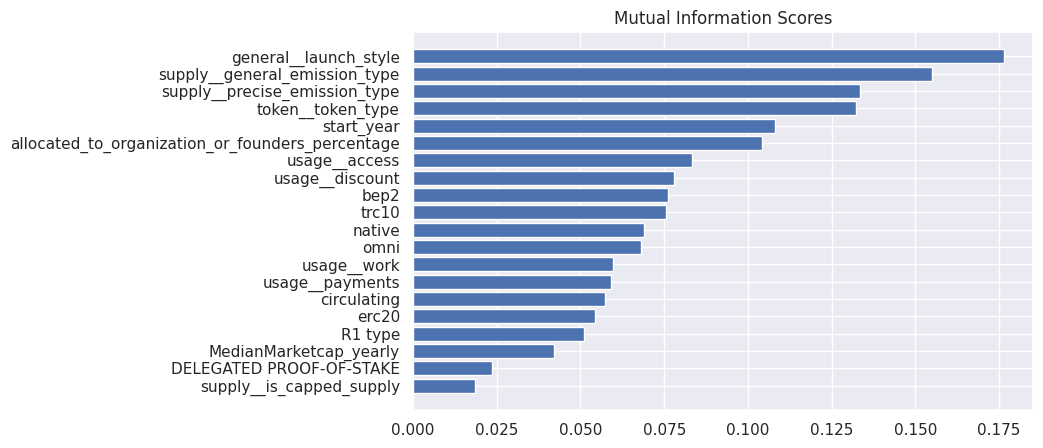

In [99]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

# logged market cap to see better plot

In [101]:
cleaned_assets['logged_marketcap'] = np.log(cleaned_assets["current_marketcap_usd"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0.98, 'Marketcap of coins by token type')

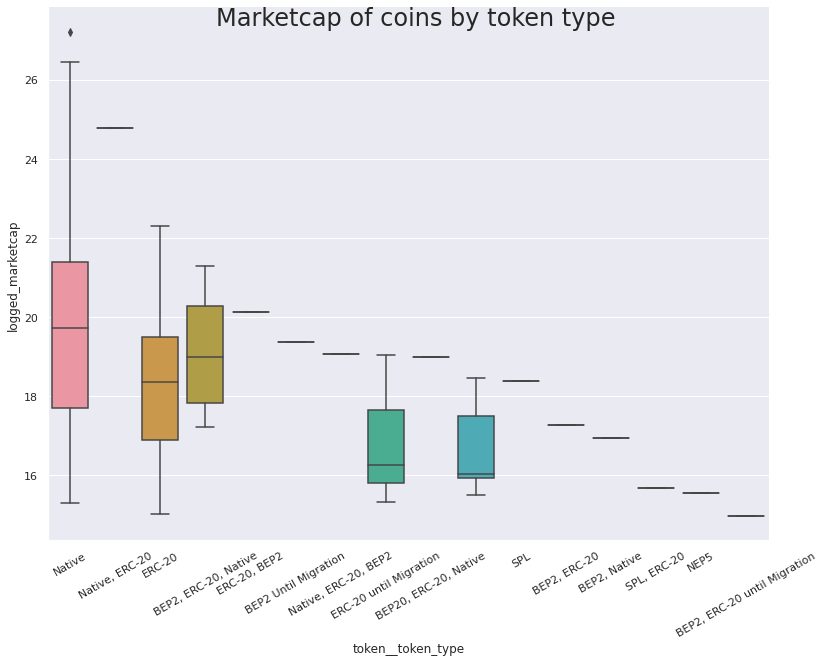

In [102]:
ax = sns.catplot(x="token__token_type", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by token type",
                  fontsize=24, fontdict={"weight": "bold"})

Text(0.5, 0.98, 'Marketcap of coins by year')

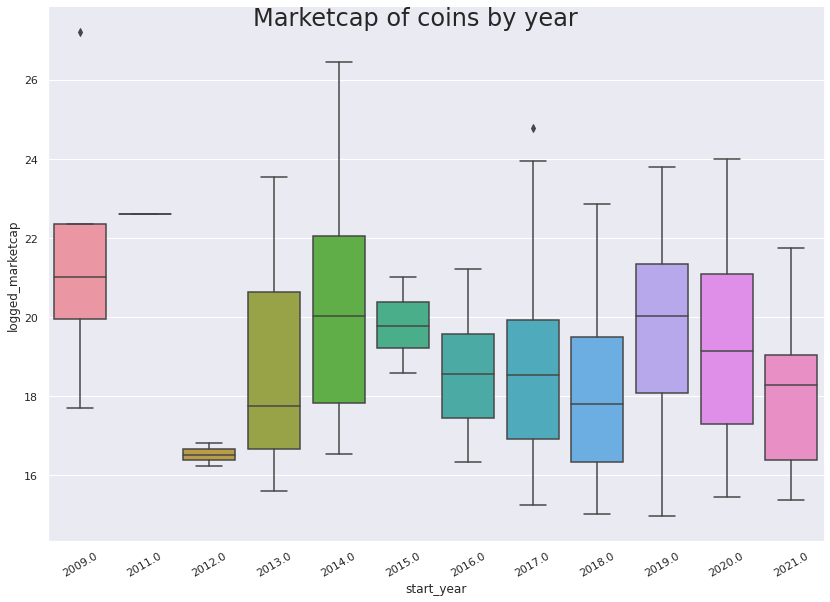

In [103]:
ax = sns.catplot(x="start_year", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by year",
                  fontsize=24, fontdict={"weight": "bold"})

Text(0.5, 1.0, 'Current Median Marketcap of coins by their start year')

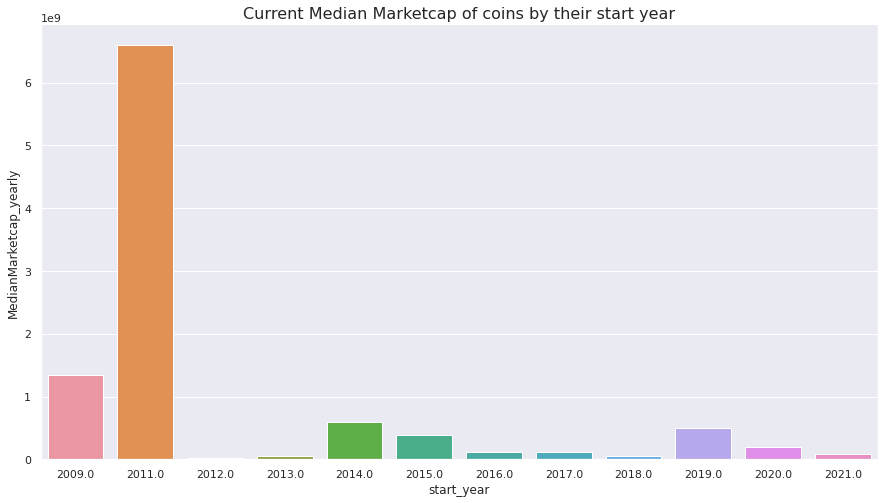

In [168]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data=cleaned_assets, x="start_year", y="MedianMarketcap_yearly")
ax.set_title("Current Median Marketcap of coins by their start year", loc="center",fontsize=16)
# annotate largest coin per year

Text(0.5, 0.98, 'Marketcap of coins by general launch style')

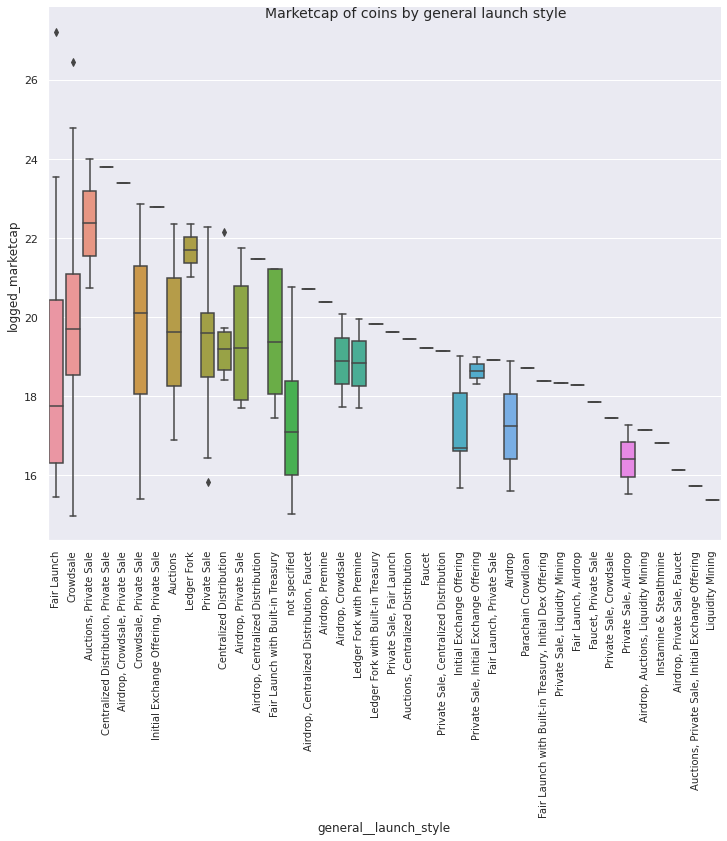

In [166]:
ax = sns.catplot(x="general__launch_style", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=90,fontsize=10)
ax.fig.suptitle("Marketcap of coins by general launch style",
                  fontsize=14, fontdict={"weight": "bold"})

In [120]:
# median market cap based on launch style
# get average marketcap per year
categorized_df["MedianMarketcap_launchstyle"] = (
    combined_df.groupby("general__launch_style")
    ["current_marketcap_usd"]
    .transform("median")
) 

categorized_df[["general__launch_style", "MedianMarketcap_launchstyle"]].head(10)

,general__launch_style,MedianMarketcap_launchstyle
0,Fair Launch,5.050224e+07
1,Crowdsale,3.532605e+08
3,Crowdsale,3.532605e+08
6,"Auctions, Private Sale",1.366692e+10
7,Crowdsale,3.532605e+08
8,"Centralized Distribution, Private Sale",2.133582e+10
11,Fair Launch,5.050224e+07
12,"Airdrop, Crowdsale, Private Sale",1.444531e+10
13,Crowdsale,3.532605e+08
16,"Crowdsale, Private Sale",5.316205e+08


Text(0, 0.5, 'Market cap')

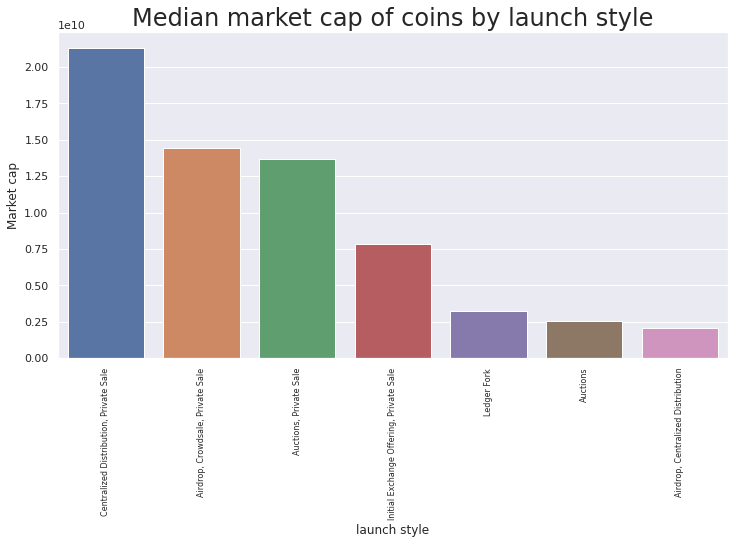

In [163]:
ax = sns.barplot(x="general__launch_style", y="MedianMarketcap_launchstyle", data=categorized_df.sort_values(by='MedianMarketcap_launchstyle',ascending=False).head(10))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by launch style",fontsize=24)
plt.xlabel('launch style',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

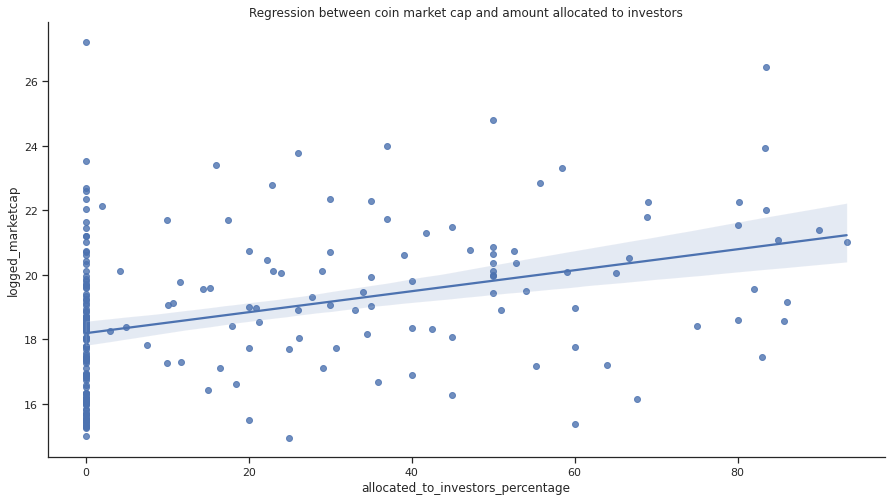

In [105]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center")
sns.despine()

#ax = sns.regplot(x="allocated_to_investors_percentage", x="allocated_to_investors_percentage", data=cleaned_assets)

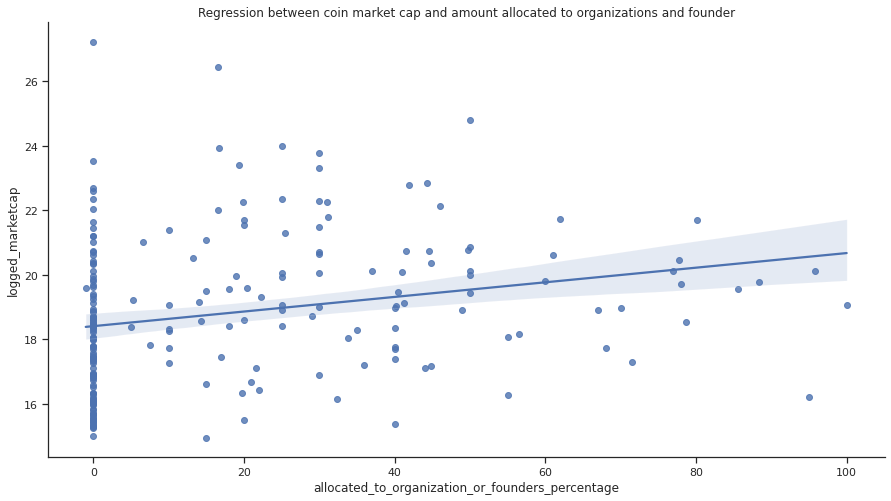

In [106]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder", loc="center")
sns.despine()


## Removing 0s from founder

In [107]:
alloc_founders = cleaned_assets[['asset','allocated_to_organization_or_founders_percentage','current_marketcap_usd','logged_marketcap']]

alloc_founders  = alloc_founders[alloc_founders['allocated_to_organization_or_founders_percentage'] != 0]
alloc_founders.shape

(107, 4)

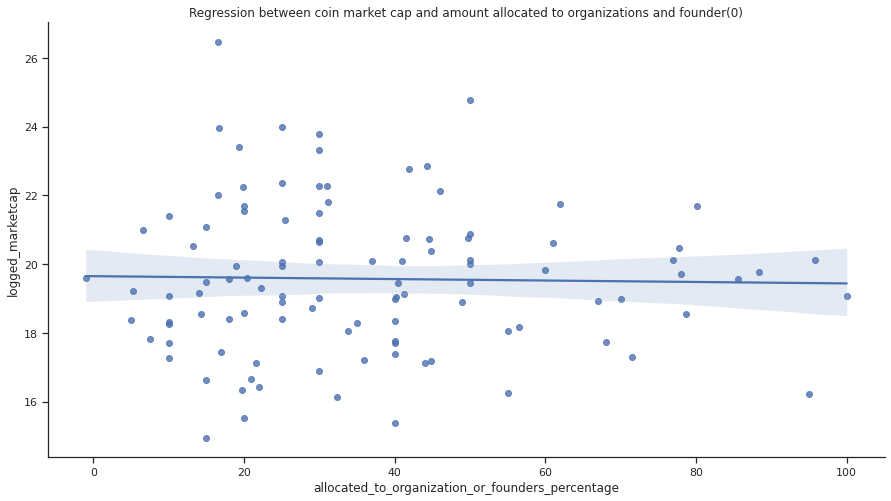

In [108]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=alloc_founders)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder(0)", loc="center")
sns.despine()



## removing 0s from investors

In [118]:
alloc_invest = cleaned_assets[['asset','allocated_to_investors_percentage','current_marketcap_usd','logged_marketcap']]
alloc_invest  = alloc_invest[alloc_invest['allocated_to_investors_percentage'] != 0]
alloc_invest.shape

(99, 4)

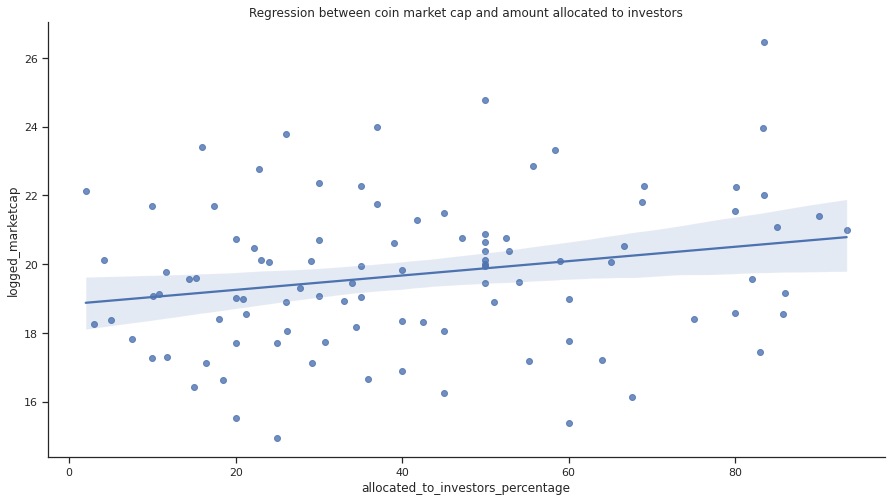

In [110]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=alloc_invest)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center")
sns.despine()
